In [24]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [34]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import random

#生成1010的序列
def generate_real():
    real_data = torch.FloatTensor([random.uniform(0.8,1.0),random.uniform(0.0,0.1),
                                  random.uniform(0.8,1.0),random.uniform(0.0,0.1)])
    return real_data

def generate_random(size):
    random = torch.rand(size)
    return random
'生成符合1010的数：',generate_real()
'生成随机的数：',generate_random(4)

('生成符合1010的数：', tensor([0.9877, 0.0544, 0.9539, 0.0784]))

('生成随机的数：', tensor([0.6692, 0.1820, 0.2424, 0.0573]))

In [35]:
#构建判别器

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(nn.Linear(4,3),
                                   nn.ReLU(),
                                   nn.Linear(3,1),
                                   nn.Sigmoid())
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(),lr=0.01)
        self.counter = 0
        self.progress = []
        
    def forward(self,input):
        return self.model(input)
    
    def train(self,inputs,targets):
        outputs = self.forward(inputs)
        loss = self.loss(outputs,targets)
        
        self.counter += 1
        if self.counter%10 == 0:
            self.progress.append(loss.item())
            
#         if self.counter%1000 == 0:
#             print('counter = ',self.counter)
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress,columns=['loss'])
        df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.25))

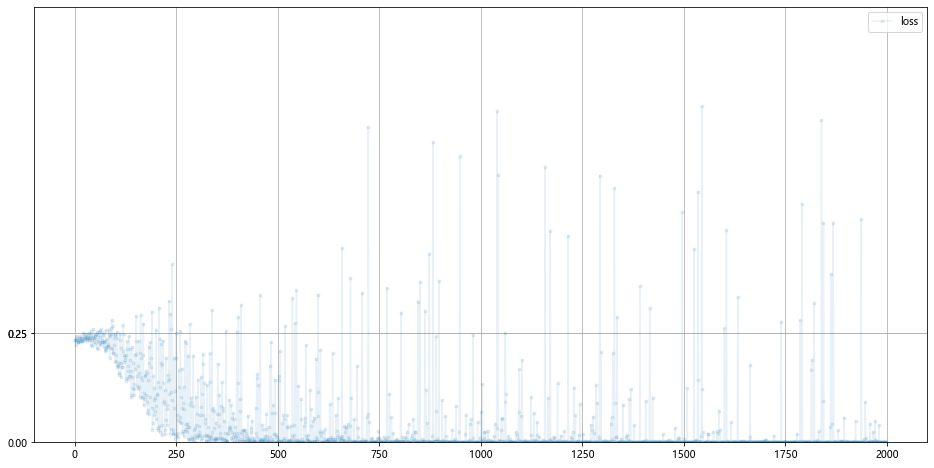

In [36]:
#训练判别器
D = Discriminator()
for i in range(10000):
    D.train(generate_real(),torch.FloatTensor([1.0]))
    D.train(generate_random(4),torch.FloatTensor([0.0]))
D.plot_progress()

In [37]:
print('判别器预测结果:',D.forward(torch.FloatTensor([0.9,0.11,0.87,0.02])))
print('判别器预测结果:',D.forward(generate_random(4)))

判别器预测结果: tensor([0.9238], grad_fn=<SigmoidBackward>)
判别器预测结果: tensor([0.0003], grad_fn=<SigmoidBackward>)


In [ ]:
#构建生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(nn.Linear(1,3),
                                   nn.ReLU(),
                                   nn.Linear(3,4),
                                   nn.Sigmoid())
#         self.loss = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(),lr=0.01)
        self.counter = 0
        self.progress = []
        
    def forward(self,input):
        return self.model(input)
    
    def train(self,D,inputs,targets):
        g_outputs = self.forward(inputs)
        d_outputs = D.forward(g_outputs)
        loss = D.loss(d_outputs,targets)
        
        self.counter += 1
        if self.counter%10 == 0:
            self.progress.append(loss.item())
            
        if self.counter%1000 == 0:
            print('counter = ',self.counter)
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress,columns=['loss'])
        df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.25))

D = Discriminator()
G = Generator()
for i in range(10000):
    D.train(generate_real(),torch.FloatTensor([1.0]))
    D.train(G.forward(torch.FloatTensor([0.5])).detach(),torch.FloatTensor([0.0]))
    G.train(D,torch.FloatTensor([0.5]),torch.FloatTensor([1.0]))

In [ ]:
#使用的是MSE，刚开始0.25代表判别器不太能具体区分输出的结果在0.5附近，均方之后就是0.25
#紧接着loss开始下降，表明判别器的性能提升可以比随机选择效果更好
#紧接着loss上升，表明判别器又无法好的识别了，因为GAN学习到了生成数据的规律
D.plot_progress()

In [ ]:
G.plot_progress()

# 生成手写数字

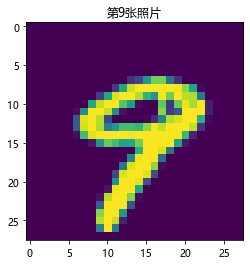

In [28]:
import torch 
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

class Minist_dataset(Dataset):
    def __init__(self,cvs_file):
        self.data_df = pd.read_csv(cvs_file,header=None)
    def __len__(self):
        return len(self.data_df)
    def __getitem__(self,index):
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0
        return label,image_values,target
    def plot_image(self,index):
        image = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.imshow(image)
        plt.title('第%d张照片'%index)
        
mnist = Minist_dataset(r'D:\浏览器下载\mnist_test (1).csv')
mnist.plot_image(9)

In [48]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(nn.Linear(784,200),
                                    nn.LeakyReLU(0.02),
                                    nn.LayerNorm(200),
                                   nn.Linear(200,1),
                                   nn.Sigmoid())
        self.loss = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(),lr=0.001)
        self.counter = 0
        self.loss_ = []
    def forward(self,x):
        return self.model(x)
    
    def train(self,inputs,targets):
        outputs = self.forward(inputs)
        loss = self.loss(outputs,targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.loss_.append(loss.item())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_loss(self):
        plt.plot(self.loss_)
        plt.show()
def generate_random(size):
    random = torch.randn(size)
    return random


# D = Discriminator()
# for label,image,target in mnist:
#     print(image.shape)
#     D.train(image,torch.FloatTensor([1.0]))
#     D.train(generate_random(784),torch.FloatTensor([0.0]))
# D.plot_loss()

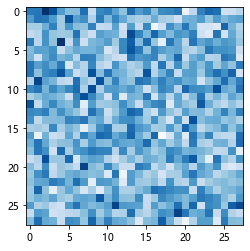

In [49]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(nn.Linear(100,200),
                                   nn.LeakyReLU(0.02),
                                   nn.LayerNorm(200),
                                   nn.Linear(200,784),
                                   nn.Sigmoid())
        self.counter = 0
        self.progress = []
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=0.001)
    def forward(self,x):
        return self.model(x)
    def train(self,D,inputs,targets):
        g_outputs = self.forward(inputs)
        d_outputs = D.forward(g_outputs)
        loss = D.loss(d_outputs,targets)
        
        self.counter += 1
        if self.counter%10 == 0:
            self.progress.append(loss.item())
            
        if self.counter%1000 == 0:
            print('counter = ',self.counter)
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress,columns=['loss'])
        df.plot(ylim=(0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.25))
        
G = Generator()
output = G.forward(generate_random(100)).detach().numpy().reshape(28,28)
plt.imshow(output,cmap='Blues')
plt.show()

In [50]:
G = Generator().cuda()
D = Discriminator().cuda()
for _ in range(8):
    for label,image_data_tensor,target_tensor in mnist:
        image_data_tensor,target_tensor = image_data_tensor.cuda(),target_tensor.cuda()
        D.train(image_data_tensor,torch.FloatTensor([1.0]).cuda())
        D.train(G.forward(generate_random(100).cuda()).detach(),torch.FloatTensor([0.0]).cuda())
        G.train(D,generate_random(100).cuda(),torch.FloatTensor([1.0]).cuda())

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counte

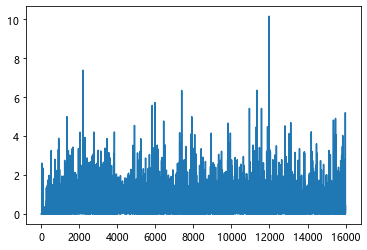

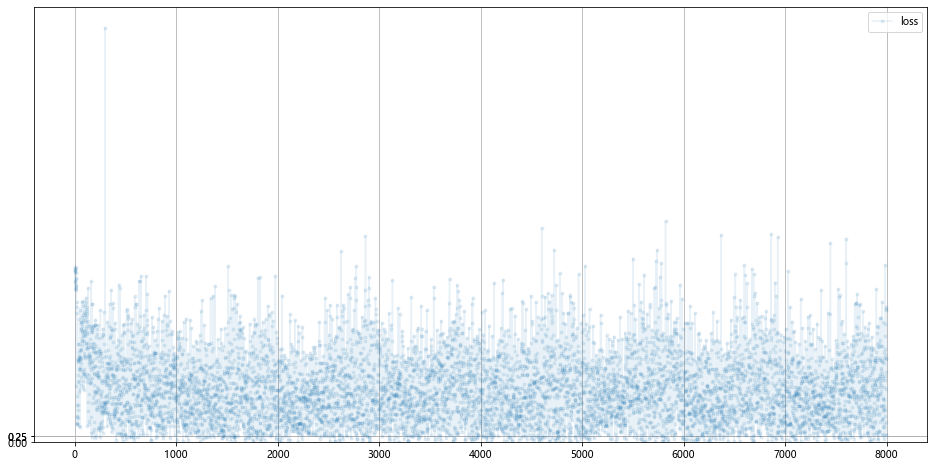

In [51]:
D.plot_loss()
G.plot_progress()

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

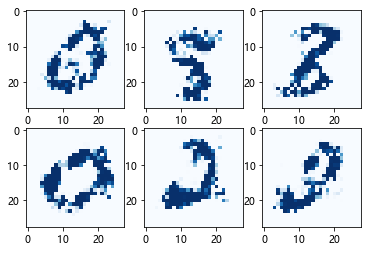

In [54]:
#模式崩溃
plt.figure()
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.imshow(G.forward(generate_random(100).cuda()).detach().cpu().numpy().reshape(28,28),cmap='Blues')
plt.show()